In [229]:
import numpy as np
from numpy import random as rnd
import scipy.io as sio
from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from scipy.stats import zscore

In [21]:
class Task(object):
    """ 
        Iterable task object
    """
    def __init__(self, max_iter=None, batch_size=1):
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.num_iter = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if (self.max_iter is None) or (self.num_iter < self.max_iter):
            self.num_iter += 1
            return (self.num_iter - 1) , self.sample()
        else:
            raise StopIteration()

    def sample(self):
        raise NotImplementedError()
        

In [86]:
class KalmanFilteringTaskFFWD(Task):
    '''Parameters'''
    def __init__(self, max_iter=None, batch_size=1, n_in=50, n_out=1, stim_dur=10, sigtc_sq=4.0, signu_sq=1.0, gamma=0.1, tr_cond='all_gains'):
        super(KalmanFilteringTaskFFWD, self).__init__(max_iter=max_iter, batch_size=batch_size)
        self.batch_size = batch_size        
        self.n_in       = n_in
        self.n_out      = n_out
        self.stim_dur   = stim_dur
        self.sigtc_sq   = sigtc_sq
        self.signu_sq   = signu_sq
        self.gamma      = gamma # controls how much the hidden state is going to change per timestep
        self.tr_cond    = tr_cond # how reliable is sensory information (not of huge importance to us either)
        self.phi        = np.linspace(-9.0, 9.0, self.n_in) # Phi is the input tuning function

    def sample(self):
        
        NU         = np.sqrt(self.signu_sq) * np.random.randn(self.stim_dur, self.batch_size)
        R          = np.zeros((self.n_in, self.stim_dur, self.batch_size))
        S          = np.zeros((1, self.stim_dur, self.batch_size))
        M          = np.zeros((1, self.stim_dur, self.batch_size))        
        SIG_SQ     = np.zeros((1, self.stim_dur, self.batch_size))
        M_IN       = np.zeros((1, self.stim_dur, self.batch_size))
        SIG_SQ_IN  = np.zeros((1, self.stim_dur, self.batch_size))
        
        A_in       = np.ones((1, self.n_in))
        B_in       = self.phi
        
        if self.tr_cond == 'all_gains':
            G         = (3.0 - 0.3) * np.random.rand(self.stim_dur, self.batch_size) + 0.3
        elif self.tr_cond == 'high_gain': 
            G = np.full((self.stim_dur, self.batch_size),3)
        else:
            G         = np.random.choice([0.3, 3.0],(self.stim_dur, self.batch_size))

        for ii in range(self.batch_size):
            S[0,0,ii]         = np.sqrt(self.signu_sq) * np.random.randn()
            R[:,0,ii]         = G[0,ii] * np.exp(- ((S[0,0,ii] - self.phi) / (np.sqrt(2.0 * self.sigtc_sq))) ** 2)
            R[:,0,ii]         = np.random.poisson(R[:,0,ii])
            M[0,0,ii]         = np.dot(B_in, R[:,0,ii]) / (np.dot(A_in, R[:,0,ii]) + (self.sigtc_sq/self.signu_sq))
            SIG_SQ[0,0,ii]    = 1.0 / ( np.dot(A_in, R[:,0,ii]) / self.sigtc_sq + (1.0 / self.signu_sq))
            M_IN[0,0,ii]      = M[0,0,ii]
            SIG_SQ_IN[0,0,ii] = SIG_SQ[0,0,ii]
            
            for tt in range(1,self.stim_dur):
                # Draw the new mean of the generating process s_t 
                S[0,tt,ii]         = (1.0 - self.gamma) * S[0,tt-1,ii] + NU[tt,ii]
                # Draw new stimulus input through poisson draws w/ rate drawn according to tuning function
                R[:,tt,ii]         = G[tt,ii] * np.exp(- ((S[0,tt,ii] - self.phi) / (np.sqrt(2.0 * self.sigtc_sq))) ** 2)
                R[:,tt,ii]         = np.random.poisson(R[:,tt,ii])
               
                natparam_1_in      = np.dot(B_in, R[:,tt,ii]) / self.sigtc_sq
                natparam_2_in      = np.dot(A_in, R[:,tt,ii]) / self.sigtc_sq
               
                M_IN[0,tt,ii]      = natparam_1_in / natparam_2_in
                SIG_SQ_IN[0,tt,ii] = 1.0 / natparam_2_in
               
                K                  = self.signu_sq + (1.0-self.gamma)**2 * SIG_SQ[0,tt-1,ii]
                       
                M[0,tt,ii]         = ( np.dot(B_in, R[:,tt,ii]) * K + (1.0-self.gamma) * M[0,tt-1,ii] * self.sigtc_sq) / ( np.dot(A_in, R[:,tt,ii]) * K + self.sigtc_sq)
                SIG_SQ[0,tt,ii]    = (self.sigtc_sq * K) / (np.dot(A_in, R[:,tt,ii]) * K + self.sigtc_sq)
            
        example_input         = np.swapaxes(R,0,2)
        example_output        = np.swapaxes(S,0,2)
        opt_s                 = np.swapaxes(M,0,2)

        return torch.from_numpy(example_input).double() , torch.from_numpy(example_output).double(),opt_s


In [156]:
class RecurrentModel(nn.Module):
    """
        Generalized RNN model from Rylan Schaeffer
    """
    def __init__(self,model_kwargs):
        super(RecurrentModel, self).__init__()
        self.model_kwargs = model_kwargs
        self.input_size = model_kwargs['input_size']
        self.output_size = model_kwargs['output_size']
        self.batch_size = model_kwargs['batch_size']

        # create and save core i.e. the recurrent operation
        self.core = self._create_core(model_kwargs=model_kwargs)

        self.readout = nn.Linear( # linear output layer
            in_features=model_kwargs['core_kwargs']['hidden_size'],
            out_features=self.output_size,
            bias=True)
        
        self.readout_nonlinearity = self._create_readout_nonlinearity(model_kwargs)
        
        param_init_(self) 
        self.reset_core_hidden()

        # converts all weights into doubles i.e. float64
        # this prevents PyTorch from breaking when multiplying float32 * float64
        self.double()

    def _create_core(self, model_kwargs):
        core = nn.RNN(
            input_size=self.input_size,
            batch_first=True,
            **model_kwargs['core_kwargs'])
        return core
    
    def _create_readout_nonlinearity(self,model_kwargs): 
        if model_kwargs['readout_nonlinearity'] == "sigmoid": 
            return torch.sigmoid
        elif model_kwargs['readout_nonlinearity'] == "linear":
            return torch.nn.Identity(self.model_kwargs['core_kwargs']['hidden_size'])
        elif model_kwargs['readout_nonlinearity'] == "elu": 
            return torch.nn.ELU

    def reset_core_hidden(self):
        self.core_hidden = torch.zeros(self.output_size,self.batch_size,self.model_kwargs['core_kwargs']['hidden_size'],dtype = torch.double)

    def forward(self,x):
        """
        Performs a forward pass through model.

        :param model_input: Tensor with shape (batch size, num step, stimulus dimension)
            
        :return forward_output: dictionary containing 4 keys:
            core_output: Tensor of shape (batch size, num steps, core dimension)
            readout_output: Tensor of shape (batch size, num steps, core dimension)
            readout: Tensor of shape (batch size, num steps, output dimension)
        """ 
        # reset hidden 
        self.reset_core_hidden()
        
        # run trials and get core output
        core_output, new_core_hidden = self.core(x,self.core_hidden)
                
        readout_output = self.readout_nonlinearity(self.readout(core_output))
        
        forward_output = dict(
            core_output = core_output,
            readout_output = readout_output)

        return forward_output

# parameter initialization functions 
def diag_init(tensor: torch.Tensor, offdiag_val : np.float64, diag_val: np.float64) -> torch.Tensor:
    """ 
        Initialize parameters, separating onn and off diag
        In place operation
    """
    shape = tensor.shape
    if len(shape) != 2 or shape[0] != shape[1]:
        raise ValueError('LeInit initializer can only be used for 2D square matrices.')

    off_diag_part = offdiag_val * np.random.randn(shape[0], shape[1])
    tensor = torch.tensor(np.eye(shape[0]) * diag_val + off_diag_part - np.diag(np.diag(off_diag_part)))
    return tensor

def param_init_(recurrent_model):    
    param_init_kwargs = recurrent_model.model_kwargs['param_init_kwargs'] 
#     with torch.no_grad():
    if recurrent_model.model_kwargs['param_init_fn'] == "diag_init_": 
        # Init input-hidden according to Xavier Normal, g = 0.95
        nn.init.xavier_normal_(recurrent_model.core.weight_ih_l0,gain = 0.95).double()
        # Init hidden-hidden according to diag-off-diag decomposition method
        recurrent_model.core.weight_hh_l0 = torch.nn.Parameter(diag_init(recurrent_model.core.weight_hh_l0,param_init_kwargs['offdiag_val'],param_init_kwargs['diag_val'])).double()
        # Init hidden-output according to Xavier Normal, g = 0.95
        nn.init.xavier_normal_(recurrent_model.readout.weight,gain = 0.95).double()


In [429]:
def peaksort_vis_trial(core_activity : torch.Tensor,ax = None): 
    """
        Peaksort visualization of network activity during task
    """ 
    core_activity = core_activity.detach().numpy().T
    core_activity = core_activity[np.any(core_activity!= 0,1),:]
    ix = np.argmax(core_activity,1)
    peaksort = np.argsort(ix)
    if ax: 
        ax.imshow(np.flipud(core_activity[peaksort,:] / np.max(core_activity,1)[peaksort,np.newaxis]),cmap = 'jet')
    else:
        plt.imshow(np.flipud(core_activity[peaksort,:] / np.max(core_activity,1)[peaksort,np.newaxis]),cmap = 'jet')


In [159]:
# ok first figure out what's going on with this task
tr_cond = 'high_gain'
n_iter = 25001
stim_dur = 100
generator = KalmanFilteringTaskFFWD(max_iter=n_iter, batch_size=50, n_in=50, n_out=1, stim_dur=stim_dur, sigtc_sq=4.0, signu_sq=1.0, gamma=0.1, tr_cond=tr_cond)

example_input, example_output, opt_s = generator.sample()
print(example_input.shape)
print(example_output.shape)
print(opt_s.shape)

torch.Size([50, 100, 50])
torch.Size([50, 100, 1])
(50, 100, 1)


Text(0.5, 1.0, 'Stimulus Input')

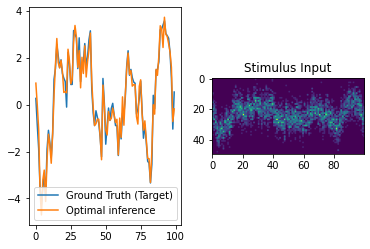

In [160]:
# ok, looking cool
trial = 5
fig,ax = plt.subplots(1,2)
ax[0].plot(example_output[trial],label = "Ground Truth (Target)") 
ax[0].plot(opt_s[trial],label = "Optimal inference")
ax[0].legend()
ax[1].imshow(np.flipud(example_input[trial].T))
ax[1].set_title("Stimulus Input")


In [161]:
# define model parameters
n_in = 50
n_out = 1
n_hid =  500
nonlinearity = 'relu'
readout_nonlinearity = 'linear'
model_kwargs = {
                'input_size': n_in, # input: patch_on,patch_off,rew,time_on_patch,time_since_rew
                'output_size': n_out,
                'batch_size': 50,
                'core_kwargs': {
                    'num_layers': 1, 
                    'hidden_size': n_hid,
                    'nonlinearity': nonlinearity},
                'param_init_fn': 'diag_init_',
                'param_init_kwargs': 
                    {
                        'offdiag_val': 0 / np.sqrt(n_hid),
                        'diag_val': .98 
                    },
                'readout_nonlinearity': readout_nonlinearity,
                'connectivity_kwargs': { 
                    'input_mask': 'none',
                    'recurrent_mask': 'none',
                    'readout_mask': 'none',
                                        },
                }

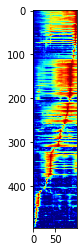

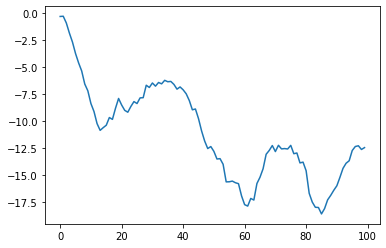

In [170]:
# Now let's run it through the RNN
trial = 5
model = RecurrentModel(model_kwargs)
model.readout_nonlinearity
output_dict = model.forward(example_input)
plt.figure(figsize = (20,4))
peaksort_vis_trial(output_dict['core_output'][trial])
plt.figure()
plt.plot(output_dict['readout_output'][trial].detach().numpy())

In [146]:
def gradClamp(parameters, clip=100):
    """
        Element-wise gradient clipping
    """
    for p in parameters:
        p.grad.data.clamp_(-clip,clip)

def binary_crossentropy(x,target,readout_clip = 1e-6): 
    """
        Compute the binary cross-entropy between predictions and targets.
    """
    x = torch.clamp(x,readout_clip,1-readout_clip)
    return - target * torch.log(x) - (1 - target) * torch.log(1 - x)

In [222]:
# Ready the training
tr_cond = 'high_gain'
n_batches = 25001
stim_dur = 100
task = KalmanFilteringTaskFFWD(max_iter=n_batches, batch_size=50, n_in=50, n_out=1, stim_dur=stim_dur, sigtc_sq=4.0, signu_sq=1.0, gamma=0, tr_cond=tr_cond)
model = RecurrentModel(model_kwargs)

# Training parameters
activity_l2_penalty = 1e-4 
activity_penalty_steps = 5 # number of activity steps before trial end to penalize
param_l2_penalty = 1e-4 # (aka weight decay)
lr = 0.0005
grad_clip = 100
ce_loss = nn.CrossEntropyLoss(reduction = "mean")
mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr) # , weight_decay = param_l2_penalty)
total_losses = np.zeros(n_batches)
mse_losses = np.zeros(n_batches)


In [223]:
# # Just apply double
# model.double()

# TRAINING
s_vec, opt_s_vec, ex_pred_vec, frac_rmse_vec = [], [], [], []
for i, (example_input, example_output, opt_s) in task: # loop over batches in training set 
    optimizer.zero_grad() # zero the gradients
    output_dict = model.forward(example_input) # perform forward pass
    
    opt_vec.append(opt_s)
    net_vec.append(output_dict['readout_output'].detach().numpy())
    
    # calculate loss
    this_mse_loss = torch.sqrt(mse_loss(output_dict['readout_output'][:,:,-1],example_output[:,:,-1]))

    loss = (this_mse_loss).double() # activity_l2_loss 
    loss.backward() # backpropagate gradients
    gradClamp(model.parameters(), clip = grad_clip) # clip gradients 
    optimizer.step() # perform optimization step
    
    total_losses[i] = loss.item() 
    mse_losses[i] = this_mse_loss.item()
    
    s_vec.append(example_output[:,:,-1].detach().numpy())
    opt_s_vec.append(opt_s[:,:,-1])
    ex_pred_vec.append(output_dict['readout_output'].detach().numpy()[:,:,-1])

    if i % 5 == 0:
        rmse_opt  = np.sqrt(np.nanmean((np.asarray(s_vec) - np.asarray(opt_s_vec))**2))
        rmse_net  = np.sqrt(np.nanmean((np.asarray(s_vec) - np.squeeze(np.asarray(ex_pred_vec)))**2))
        frac_rmse = (rmse_net - rmse_opt) / rmse_opt
        frac_rmse_vec.append(frac_rmse)
        print('Batch #%d; Frac. RMSE: %.6f; Opt. RMSE: %.6f; Net. RMSE: %.6f' % (i, frac_rmse, rmse_opt, rmse_net))
        s_vec       = []
        opt_s_vec   = []
        ex_pred_vec = []
        

<ipython-input-86-adcfd5d87e45>:54: RuntimeWarning: invalid value encountered in true_divide
  M_IN[0,tt,ii]      = natparam_1_in / natparam_2_in
<ipython-input-86-adcfd5d87e45>:55: RuntimeWarning: divide by zero encountered in true_divide
  SIG_SQ_IN[0,tt,ii] = 1.0 / natparam_2_in


Batch #0; Frac. RMSE: 1.537574; Opt. RMSE: 3.776499; Net. RMSE: 9.583144
Batch #5; Frac. RMSE: 183.206543; Opt. RMSE: 2.255811; Net. RMSE: 415.535165
Batch #10; Frac. RMSE: 1.721627; Opt. RMSE: 2.822193; Net. RMSE: 7.680955
Batch #15; Frac. RMSE: 1.164173; Opt. RMSE: 2.736546; Net. RMSE: 5.922358
Batch #20; Frac. RMSE: 1.035423; Opt. RMSE: 2.368942; Net. RMSE: 4.821799
Batch #25; Frac. RMSE: 0.849698; Opt. RMSE: 2.305621; Net. RMSE: 4.264701
Batch #30; Frac. RMSE: 0.658701; Opt. RMSE: 2.548474; Net. RMSE: 4.227158
Batch #35; Frac. RMSE: 0.623824; Opt. RMSE: 2.260303; Net. RMSE: 3.670335
Batch #40; Frac. RMSE: 0.382413; Opt. RMSE: 2.694469; Net. RMSE: 3.724868
Batch #45; Frac. RMSE: 0.269985; Opt. RMSE: 2.529858; Net. RMSE: 3.212881
Batch #50; Frac. RMSE: 0.319259; Opt. RMSE: 2.544029; Net. RMSE: 3.356233
Batch #55; Frac. RMSE: 0.272451; Opt. RMSE: 2.435689; Net. RMSE: 3.099295
Batch #60; Frac. RMSE: 0.106119; Opt. RMSE: 3.281337; Net. RMSE: 3.629550
Batch #65; Frac. RMSE: 0.167859; Opt

KeyboardInterrupt: 

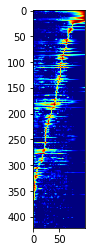

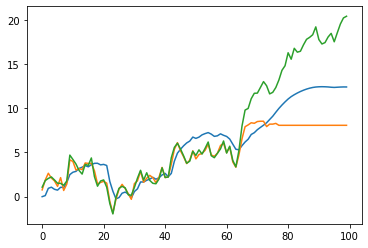

In [224]:
trial = 0
plt.figure()
peaksort_vis_trial(output_dict['core_output'][trial])
plt.figure()
plt.plot(output_dict['readout_output'][trial,:,-1].detach().numpy())
plt.plot(opt_s[0,:,-1])
plt.plot(example_output[0,:,-1])

## Now create task for Point Process Filtering 

We take the setting of a point process. Let the reward events $0 < u_1 < u_2 < ... < u_L$ be a realization from a point process with conditional intensity function $\lambda(u | H_u)$ where $u$ is a continuous-valued non-negative variable that denotes continuous time. N.B. we will use $t$ to denote a discrete time index. Let $N(u)$ be the associated counting process.

By definition of the CIF: 

$$P(N(u + \Delta) - N(u) = 1 | H_u ) \approx \lambda(u|H_u)\Delta + o(\Delta)  $$

s.t. with small enough discretization $\Delta$, $y_t \in \{0,1\}$

$$p(y_t | H_t) = (\lambda(t | H_t)\Delta)^y e^{-\lambda (t|H_t)\Delta}   $$


Then let $\lambda(t | \theta_t,H_t) = e^{\theta_t}$
We adopt a SRW on the dynamics of $\theta_t$ s.t. $\theta_t = \theta_{t-1} + \epsilon_{t}$ where $\epsilon_t \sim N(0,\sigma_\epsilon^2)$. This yields $\sigma_{t|t-1}^2 = \sigma_{t-1|t-1}^2 + \sigma_{\epsilon}^2 $

Solving the filtering equation, we arrive at: 

$$\theta_{t|t} = \theta_{t | t-1} + \sigma_{t|t}^2 (y_t - e^{\theta_{t|t-1}}\Delta ) = \theta_{t | t-1} + \sigma_{t|t}^2 (y_t - \lambda(t | \theta_{t},H_t)\Delta ) $$

$$\sigma_{t|t}^2 = \left(\lambda(t | \theta_{t-1},H_t)\Delta + \frac{1}{\sigma_{t|t-1}^2}   \right)^{-1} $$

We will initialize $\theta_{0|0}$ and $\sigma^2_{0|0}$ according to some prior distribution.


In [448]:
# Event stream generating functions
def stream_from_events(event_times,end_t,dt = 0.05): 
    """ 
        Convert event times into a binary stream of continuous data
    """ 
    rew_ix = np.round(event_times / dt).astype(int)
    rew_stream = np.zeros(int(np.round(end_t / dt)))
    rew_stream[rew_ix] = 1
    return rew_stream

def stream_from_sized_events(event_times,event_sizes,end_t,dt = 0.05): 
    """
        Approximate rewards of varying sizes by using multiple positive events in a row
    """
    rew_ix = np.round(event_times / dt).astype(int)
    rew_stream = np.zeros(int(np.round(end_t / dt)))
    for ix,dur in zip(rew_ix,event_sizes):
        rew_stream[ix:ix+dur] = 1
    return rew_stream

# Foraging session point process generation functions
def discrete_expo_pdf(N0,n_rew_locs = 20,tau = .125):
    """
        Assign reward delivery probabilities according to scaled Expo decay
    """
    x = np.arange(n_rew_locs)
    cdf = 1 - N0 * np.exp(-tau * x) / tau + N0 / tau
    pdf = cdf[1:] - cdf[:-1]
    return np.insert(pdf,0,1.) # add a deterministic reward at t = 0

def generate_session_y(rewsizes,N0s,n_trials_per_tt,end_t = 20,dt = 0.05): 
    """
        Arguments: list of reward sizes and N0 values and # trials per trial type
        Returns: y_tts_trials: dictionary with trial type keys and n_trials_per_tt streams of reward
            - y generated with stream_from_sized_events
    """
    # make PDFs
    pdfs_dict = {}
    for this_n0 in N0s: 
        pdfs_dict[this_n0] = discrete_expo_pdf(this_n0,n_rew_locs = end_t)
    
    # make trial reward streams
    y_tts_trials = {}
    tts = list(product(*[rewsizes,N0s]))
#     print(tts)
    for (this_rewsize,this_n0) in tts: 
        y_tts_trials[(this_rewsize,this_n0)] = np.empty_like([n_trials_per_tt],shape = (n_trials_per_tt,int(round(end_t/dt))))
        for i_trial in range(n_trials_per_tt): 
            trial_rewtimes = np.where(rnd.random(end_t) - pdfs_dict[this_n0] < 0)[0]
#             print(trial_rewtimes)
            y_trial = stream_from_sized_events(trial_rewtimes,np.full(len(trial_rewtimes),this_rewsize),end_t,dt)
            y_tts_trials[(this_rewsize,this_n0)][i_trial,:] = y_trial
    return y_tts_trials

def generate_from_rewtimes_y(rewsizes,rewseqs,n_trials_per_tt,end_t = 20,dt = 0.05): 
    """ 
        Arguments: dict of reward sizes,subplist of  reward time sequences 
        Returns: y_tts_trials: list of y reward streams generated from stream_from_sized_events
    """
    y_tts_trials = {}
    tts = list(product(*[rewsizes,rewseqs]))
    for (this_rewsize,this_rewseq) in tts: 
        y_tts_trials[(this_rewsize,this_rewseq)] = np.tile(stream_from_sized_events(this_rewseq,np.full(len(this_rewseq),this_rewsize),end_t,dt),(n_trials_per_tt,1))
    return y_tts_trials


In [449]:
class PPSSM_FilteringTask(Task):
    """ 
        Filter point process to return estimated lambda 
        
        Use foraging session function to create the generative point process (S)
    """
    def __init__(self,ppssm_params,max_iter=None, n_in=50,sigtc_sq=.02,tr_cond='high_gain'):
        super(PPSSM_FilteringTask, self).__init__(ppssm_params)
        self.n_in       = n_in
        self.ppssm_params = ppssm_params
        self.y_generator, self.stim_dur, self.batch_size = self._create_PPSSM_generating_fn()
        
        self.tr_cond    = tr_cond # how reliable is sensory information
        # Phi is the input tuning function
        self.phi        = np.linspace(0, 1, self.n_in) # For some reward cells and some no-reward cells
#         self.phi        = np.ones(self.n_in) # Input only to reward
        self.sigtc_sq   = sigtc_sq
    
    def _create_PPSSM_generating_fn(self):
        gen_fn_params = self.ppssm_params["generation_params"]
        if self.ppssm_params["generation_fn"] == "stochastic_foraging_session": 
            y_generator = generate_session_y 
            n_tts = len(list(product(*[gen_fn_params['rewsizes'],gen_fn_params['N0s']])))
            stim_dur = int(np.round(gen_fn_params['end_t'] / gen_fn_params['dt']))
            batch_size = int(gen_fn_params['n_trials_per_tt'] * n_tts)
        elif self.ppssm_params["generation_fn"] == "rewtimes_foraging_session": 
            y_generator = generate_from_rewtimes_y
            n_tts = len(list(product(*[gen_fn_params['rewsizes'],gen_fn_params['rewseqs']])))
            stim_dur = int(np.round(gen_fn_params['end_t'] / gen_fn_params['dt'])) 
            batch_size = int(gen_fn_params['n_trials_per_tt'] * n_tts)
        return y_generator,stim_dur,batch_size
        
    def sample(self):
        # Set trial stimulus gains
        if self.tr_cond == 'all_gains':
            G         = (3.0 - 0.3) * np.random.rand(self.stim_dur, self.batch_size) + 0.3
        elif self.tr_cond == 'high_gain': 
            G         = np.full((self.stim_dur, self.batch_size),3)
        else:
            G         = np.random.choice([0.3, 3.0],(self.stim_dur, self.batch_size))
            
        # make session and flatten it to get training batch
        y_dict     = self.y_generator(**self.ppssm_params['generation_params'])
        S          = np.concatenate([y_dict[i] for i in y_dict.keys()]).T[np.newaxis,:,:]
        # initialize input neuron response tensor
        R          = np.zeros((self.n_in, self.stim_dur, self.batch_size))
        
        # Initialize parameters for optimal filtering from sensory input
        M          = np.zeros((1, self.stim_dur, self.batch_size))        
        SIG_SQ     = np.zeros((1, self.stim_dur, self.batch_size))

        ones    = np.ones((1, self.n_in))

        for ii in range(self.batch_size): # iterate over trials
            # initialize filtering stuff for this trial
            R[:,0,ii]         = G[0,ii] * np.exp(- ((S[0,0,ii] - self.phi) / (np.sqrt(2.0 * self.sigtc_sq))) ** 2)
            R[:,0,ii]         = np.random.poisson(R[:,0,ii])
#             M[0,0,ii]         = np.dot(self.phi, R[:,0,ii]) / (np.dot(ones, R[:,0,ii]) + (self.sigtc_sq/self.signu_sq))
#             SIG_SQ[0,0,ii]    = 1.0 / ( np.dot(ones, R[:,0,ii]) / self.sigtc_sq + (1.0 / self.signu_sq))
            
            for tt in range(1,self.stim_dur): # iterate over timesteps
                # Draw new stimulus input through poisson draws w/ rate drawn according to tuning function
                R[:,tt,ii]         = G[tt,ii] * np.exp(- ((S[0,tt,ii] - self.phi) / (np.sqrt(2.0 * self.sigtc_sq))) ** 2)
                R[:,tt,ii]         = rnd.poisson(R[:,tt,ii])
               
#                 K                  = self.signu_sq + SIG_SQ[0,tt-1,ii]           
#                 M[0,tt,ii]         = (np.dot(self.phi, R[:,tt,ii]) * K + M[0,tt-1,ii] * self.sigtc_sq) / ( np.dot(ones, R[:,tt,ii]) * K + self.sigtc_sq)   
#                 SIG_SQ[0,tt,ii]    = (self.sigtc_sq * K) / (np.dot(ones_in, R[:,tt,ii]) * K + self.sigtc_sq)
            
        example_input         = np.swapaxes(R,0,2) # this will be the poisson drawn input 
        example_output        = np.swapaxes(S,0,2) # this will be the stream of reward events (ground truth)
        opt_s                 = np.swapaxes(M,0,2) # this will be output of PPSSM call

        return torch.from_numpy(example_input).double() , torch.from_numpy(example_output).double(),opt_s
    

In [450]:
# define PPSSM parameters 
ppssm_params = {"generation_fn": "stochastic_foraging_session", # stochastic or defined by reward times
                "generation_params":
                           {"rewsizes":[4],
                           "N0s":[.5],
                           "n_trials_per_tt": 20,
                           "dt": 0.050,
                           "end_t" : 5}
                            }


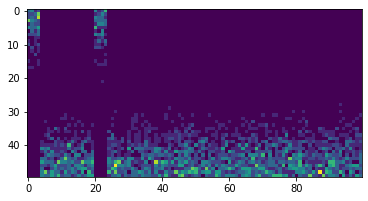

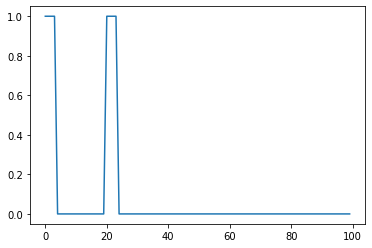

In [451]:
task = PPSSM_FilteringTask(ppssm_params = ppssm_params)
example_input,example_output,opt_s = task.sample() 
plt.imshow(np.flipud(example_input[12].detach().numpy().T))
plt.figure()
plt.plot(example_output[12].detach().numpy())

In [454]:
ppssm_params = {"generation_fn": "stochastic_foraging_session", # stochastic or defined by reward times
                "generation_params":
                           {"rewsizes":[4],
                           "N0s":[.5],
                           "n_trials_per_tt": 20,
                           "dt": 0.050,
                           "end_t" : 5}
                            }


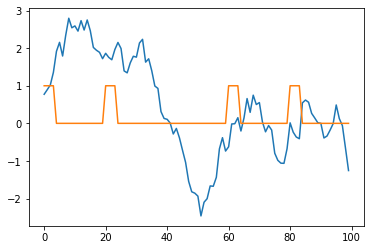

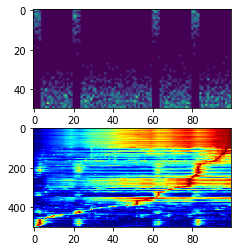

In [455]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

    
task = PPSSM_FilteringTask(ppssm_params = ppssm_params)
example_input,example_output,opt_s = task.sample() 

trial = 0
model_kwargs['batch_size'] = task.batch_size
model = RecurrentModel(model_kwargs)
output_dict = model.forward(example_input)

plt.figure()
plt.plot(output_dict['readout_output'][trial].detach().numpy())
plt.plot(example_output[trial].detach().numpy() )
fig,ax = plt.subplots(2,1)
ax[0].imshow(np.flipud(example_input[trial].detach().numpy().T))
peaksort_vis_trial(output_dict['core_output'][trial],ax = ax[1])
aspect = example_input[trial].shape[0]/example_input[trial].shape[1]

forceAspect(ax[1],aspect)


In [ ]:
g